# Hybrid Modelling

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lfm_flow.kernels import LFM1_RBF
from lfm_flow.latentforcemodels import LLFM
import tensorflow as tf

np.random.seed(123)
np.set_printoptions(precision=3, suppress=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



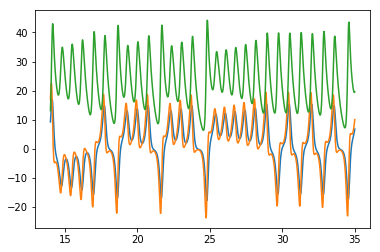

In [2]:
s = 10.
r = 28.
b = 8./3

def dXdt(X, t):
    x, y, z = X
    xdot = s*(y-x)
    ydot = x*(r-z) - y
    zdot = x*y - b*z
    return [xdot, ydot, zdot]
    
x0 = [1., 1., 1.]
tt = np.linspace(0., 35., 2000)

sol = odeint(dXdt, x0, tt)

fig, ax = plt.subplots()
ax.plot(tt[800:], sol[800:, 0])
ax.plot(tt[800:], sol[800:, 1])
ax.plot(tt[800:], sol[800:, 2])
plt.show()

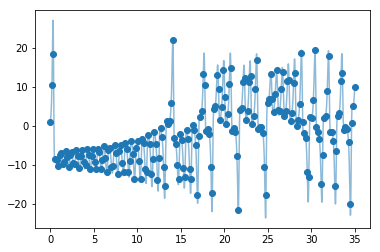

In [3]:
# subsample data
inds = np.linspace(0, tt.size-1, 200, dtype=np.intp)

times = tt[inds]
Y = sol[inds, 1]

fig, ax = plt.subplots()
ax.plot(times, Y, 'o')
ax.plot(tt, sol[:, 1], 'C0-', alpha=0.5)
#ax.set_xlim((19, 25.5))
plt.show()

In [4]:
def reset_session():
    """Creates a new global, interactive session in Graph-mode."""
    global sess
    try:
        tf.reset_default_graph()
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession()

reset_session()

lf_length_scales = np.array([.2, ])

# initial conditions for kernel -- cheat in this notebook

S0 = np.array([[3.]])
D0 = np.array([1.])

kern = LFM1_RBF(D0, S0, lf_length_scales)
lfm = LLFM(kern)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Temporary ugly adding of training data to lfm object

# concatenate to single augmented time vector...
tt_aug = np.concatenate([times,])
# ...and remember the shape of the original vectors
tt_aug_shape = [times.size,]

lfm.t_input = tt_aug
lfm.t_input_shape = tt_aug_shape

# Store training data as shape (N_obs, N_replicates)
# -- start the process at 0.
_Y = tf.constant(Y, dtype=np.float64)[:, None] - 1.
lfm.Y = _Y

In [6]:
# Build a tensorflow operator to return the log_likelihood
log_likelihood = lfm._build_likelihood()

# construct an optimiser
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(-log_likelihood)

Instructions for updating:
Use tf.cast instead.


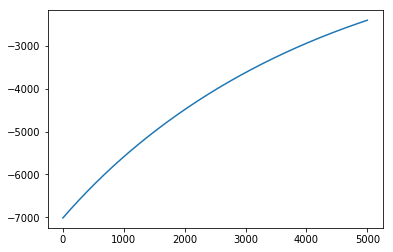

In [7]:
sess.run(tf.global_variables_initializer())

# specify no. of iterations for model fitting...
# ... and a container for the values
num_iters = 10000

def train(num_iters):
    lls_ = np.zeros(num_iters, np.float64)
    for i in range(num_iters):
        _, lls_[i] = sess.run([train_op, log_likelihood])
    return lls_

lls_ = train(num_iters)
fig, ax = plt.subplots()
lines = ax.plot(lls_[num_iters//2:], 'C0-')

In [8]:
Dhat, Shat, lf_length_scales_hat = sess.run(
    [lfm.kernel.D, lfm.kernel.S, lfm.kernel.lf_length_scales])

print(Dhat)
print(Shat)
print(lf_length_scales_hat)

[0.158]
[[13.006]]
[0.109]


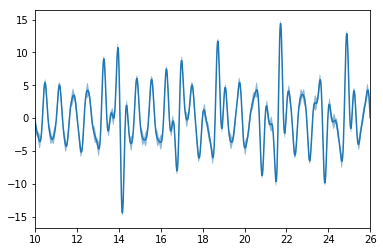

In [15]:
ttd = tt.copy()
mf, covf = lfm.predict_lf(ttd, return_cov=True)
mf, covf = sess.run([mf, covf])

fig2, ax = plt.subplots()

stdf = np.diag(covf)
stdf = np.sqrt(stdf)
ax.plot(ttd, mf, 'C0-')
ax.fill_between(ttd, mf[:, 0] + 2*stdf, mf[:, 0] - 2*stdf,
                alpha=0.5, facecolor='C0')
ax.set_xlim((10, 26))
plt.show()

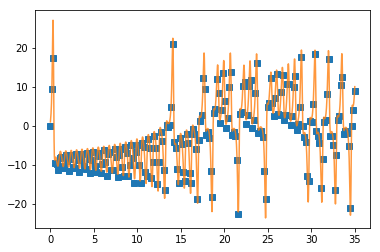

In [10]:
# take predicted func. and build a 
# cheaper to evaluate interpolant
from scipy.interpolate import interp1d

u = interp1d(ttd, mf[:, 0], kind='cubic', fill_value='extrapolate')

ysol = odeint(lambda y, t: -Dhat[0]*y + Shat[0, 0]*u(t),
             0., ttd)

uy = interp1d(ttd, ysol[:, 0] + 1., kind='cubic', fill_value='extrapolate')

fig, ax = plt.subplots()
ax.plot(times, sess.run(_Y), 's')
ax.plot(tt, sol[:, 1], '-', alpha=0.8)
#ax.set_xlim((15, 26))
plt.show()

In [11]:
def dX_dt(X_, t, uy):
    x, z = X_
    xdot = s*(uy(t)-x)
    zdot = x*uy(t) - b*z
    return [xdot, zdot]


sol2 = odeint(dX_dt, [1., 1.], tt, args=(uy,))

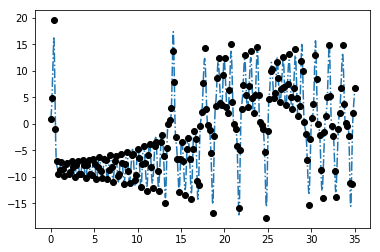

In [12]:
fig, ax = plt.subplots()
#ax.plot(tt, sol[:, 0], 'k--')
#ax.plot([tt, tt], [sol[:, 0], sol[:, 2]], 'k--')
ax.plot(tt, sol2[:, 0], 'C0-.')
ax.plot(times, sol[inds, 0], 'ko')
#ax.set_xlim((10, 25))
plt.show()

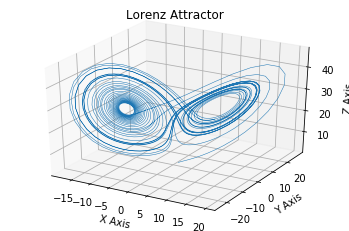

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(*sol.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
#ax.plot(sol2[:, 0], uy(tt), sol2[:, 1], lw=0.5, color='r')

ax.set_title("Lorenz Attractor")
plt.show()

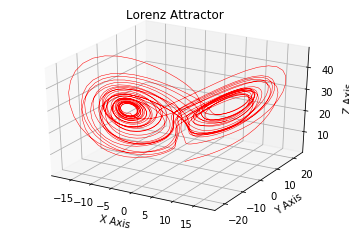

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(sol2[:, 0], uy(tt), sol2[:, 1], lw=0.5, color='r')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()